In [58]:
from ngsolve import *
from netgen.geom2d import unit_square
from ngsolve.fem import CoordinateTrafo
from netgen.meshing import Mesh as NetgenMesh
from netgen.meshing import MeshPoint, Element1D, Element0D,Pnt
from tqdm import trange
import psutil
import os
import matplotlib.pyplot as plt


In [59]:
# create 1d mesh on domain [0,1] with nel = 100 elements and 2d mesh on unit square
a,b = 0,1 
nel = 100
m = NetgenMesh()
m.dim = 1
pnums = []
for i in range(nel+1):
    x = a + (b-a)*i/nel
    pnums.append(m.Add(MeshPoint(Pnt(x, 0, 0))))
for i in range(nel):
    m.Add(Element1D([pnums[i], pnums[i+1]], index=1))
m.Add(Element0D(pnums[0], index=1))
m.Add(Element0D(pnums[nel], index=2))
mesh1d = Mesh(m)

mesh2d = Mesh(unit_square.GenerateMesh(maxh=0.1))

In [60]:
fes1d = H1(mesh1d, order=3)
fes2d = H1(mesh2d, order=3)
fct1d = GridFunction(fes1d)
fct2d = GridFunction(fes2d)
fct1d.Set(x**2)
fct2d.Set(x**2 + y**2)

Computing compositions: 100%|██████████| 1000/1000 [00:16<00:00, 60.65it/s]


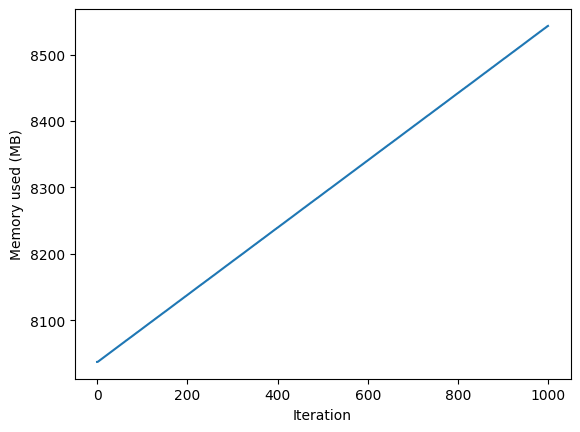

In [61]:
# computes coposition of a 1d function with a 2d function   
def composition(fct1d,fct2d): 
    a, b = 0,1 # 1d domain
    gf1d = fct1d
    gf2d = GridFunction(fes2d)
    fct2d_clipped = IfPos(fct2d - b, b, IfPos(a - fct2d, a, fct2d))
    valid = IfPos(fct2d - a, IfPos(b - fct2d, 1, 0), 0)
    f = valid*gf1d(CoordinateTrafo(CF((fct2d_clipped,0,0)), mesh1d.Materials(".*"))) 
    gf2d.Set(f) 
    return gf2d

process = psutil.Process(os.getpid())
memory_list = []

for i in trange(1000, desc="Computing compositions"):
    gf2d = composition(fct1d, fct2d) 
    mem_mb = process.memory_info().rss / 1024**2
    memory_list.append(mem_mb)
    
plt.plot(memory_list)
plt.xlabel('Iteration') 
plt.ylabel('Memory used (MB)');